In [2]:
import numpy as np
import math
import random
# from keras.datasets import mnist

--------------------------
##**Plain version**
--------------------------

-------------------------------------
Load Data and Preprocess
-------------------------------------

In [30]:
# (x_train, y_train), (x_test, y_test) = mnist.load_data()


# ## dataset of 3 and 8
# x_train = [x_train[i] for i in range(len(x_train)) if y_train[i] == 3 or y_train[i] == 8]
# y_train = [y for y in y_train if y == 3 or y == 8]
# x_test = [x_test[i] for i in range(len(x_test)) if y_test[i] == 3 or y_test[i] == 8]
# y_test = [y for y in y_test if y == 3 or y == 8]

# ## downsample to 14*14 and divide by 256
# downsampled_x_train = np.zeros((len(x_train), 14, 14), dtype=np.float64)
# downsampled_x_test = np.zeros((len(x_test), 14, 14), dtype=np.float64)

# for x in range(len(x_train)):
#   for i in range(14):
#     for j in range(14):
#       downsampled_x_train[x][i][j] = (int(x_train[x][2*i][2*j]) + int(x_train[x][2*i][2*j + 1]) 
#                                       + int(x_train[x][2*i + 1][2*j]) + int(x_train[x][2*i + 1][2*j + 1])) / 4
    
# for x in range(len(x_test)):
#   for i in range(14):
#     for j in range(14):
#       downsampled_x_test[x][i][j] = (int(x_test[x][2*i][2*j]) + int(x_test[x][2*i][2*j + 1]) 
#                                       + int(x_test[x][2*i + 1][2*j]) + int(x_test[x][2*i + 1][2*j + 1])) / 4

# ## flatten data : (num_data, 14, 14) => (num_data, 196)
# x_train = downsampled_x_train.reshape(-1, 196)
# x_test = downsampled_x_test.reshape(-1, 196)

# ## normalize
# x_train = np.array([x / max(x) for x in x_train])
# x_test = np.array([x / max(x) for x in x_test])

# ## map label 3 => -1 and 8 => 1
# y_train = [-1 if y==3 else 1 for y in y_train]
# y_test = [-1 if y==3 else 1 for y in y_test]
# print(x_train[0])

[  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     9.5   37.   127.   126.5  126.5   45.     0.
   0.     0.     0.     0.     0.     0.    55.25 216.75 245.5  252.5
 252.   252.   228.5   18.25   0.     0.     0.     0.     0.     0.
  28.25 140.5   96.5   66.25  83.75 245.5  232.    16.5    0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.    90.5  249.75
 165.5    0.     0.     0.     0.     0.     0.     0.     8.    79.5
  96.5  202.   250.75 211.    60.25   0.     0.     0.     0.     0.
   0.     0.   133.75 252.5  252.5  253.25 252.5  126.     0.     0.
   0.     0.     0.     0.     0.     0.     7.75  43.75  22.    22.
 165.5  163.     0.     0.     0.     0.     0.     0.     0.    20.
   2.25   0.     0.    24.5  208.   163.     0.     0.     0.     0.
   0.     0.    67.25 234.75  

In [3]:
# print(x_train.shape)   # (11982, 196)
# print(x_test.shape)   # (1984, 196)

(11982, 196)
(1984, 196)


-------------------------------------
Define sigmoid
-------------------------------------

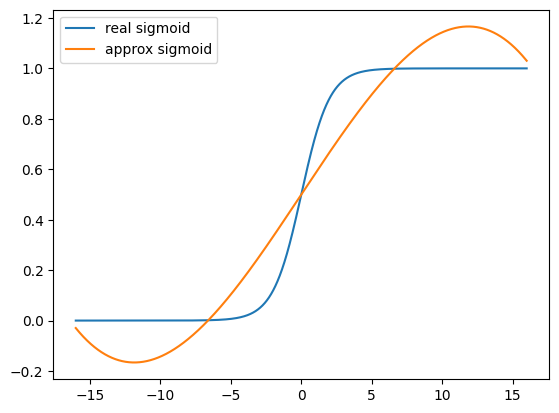

In [3]:
## check sigmoid approximation
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

def sigmoid_approx(x):
  ## sigmoid approximation for interval [-8, 8]
  # c0 = 0.5
  # c1 = 0.15
  # c3 = -0.0015

  # ## sigmoid approximation for interval [-16, 16]
  c0 = 0.5 
  c1 = -0.0843
  c3 = 0.0002

  return c3 * pow(-x, 3) - c1 * x + c0

x = np.arange(-16, 16, 0.01)
y1 = [sigmoid(x_i) for x_i in x]
y2 = [sigmoid_approx(x_i) for x_i in x]

import matplotlib.pyplot as plt
plt.plot(x, y1, label='real sigmoid')
plt.plot(x, y2, label='approx sigmoid')
plt.legend()
plt.show()

-------------------------------------
Train and Test
-------------------------------------

In [5]:
def train(x_train, y_train, block_size, learning_rate, num_iter, sigmoid):
  v = np.zeros((196 + 1), dtype=np.float64)
  w = np.zeros((196 + 1), dtype=np.float64)

  Z = np.column_stack((np.ones(len(x_train)), x_train))
  Z = [y_train[i] * Z[i] for i in range(len(x_train))]    # y_i, y_i * z_{i,1}, ..., y_i * z_{i,f}   

  alpha0 = 0.01
  alpha1 = (1 + math.sqrt(1 + 4 * alpha0 * alpha0)) / 2

  gamma = learning_rate / block_size

  for iter in range(num_iter):
    print(f'Iteration {iter + 1}')
    
    eta = (1 - alpha0) / alpha1

    # random.shuffle(Z)
    batch_Z = Z[:block_size]

    new_w = v + gamma * np.sum([sigmoid(-sum(z * w))*z for z in batch_Z], axis=0)
    new_v = (1 - eta) * new_w + eta * w

    ## update
    w = new_w
    v = new_v
    alpha0 = alpha1
    alpha1 = (1 + math.sqrt(1 + 4 * alpha0 * alpha0)) / 2

  return w

In [6]:
alpha0 = 0.01
alpha1 = (1 + math.sqrt(1 + 4 * alpha0 * alpha0)) / 2

for i in range(10):
  eta = (1 - alpha0) / alpha1
  print(eta)
  alpha0 = alpha1
  alpha1 = (1 + math.sqrt(1 + 4 * alpha0 * alpha0)) / 2

0.9899010197950513
-6.179380420078468e-05
-0.28178332043515025
-0.4340607063111451
-0.5310758788064387
-0.5987873196807789
-0.6489299451155528
-0.6876510564747608
-0.7185040554028598
-0.7436945144575158


In [26]:
def test(x_test, y_test, w, sigmoid):
  correct = 0
  for i in range(len(x_test)):
    inner_prod = (sum(np.append([1], x_test[i]) * w))

    result = sigmoid(inner_prod)
    if result >= 0.5 and y_test[i] == 1:
      correct += 1
    elif result < 0.5 and y_test[i] == -1:
      correct += 1

  accuracy = correct / len(x_test)

  return accuracy

In [27]:
## parameters
learning_rate = 1
block_size = 1024
num_iter = 32

## test and train
w = train(x_train, y_train, block_size, learning_rate, num_iter, sigmoid)
accuracy = test(x_test, y_test, w, sigmoid)

## test and train with sigmoid approximation
w_approx = train(x_train, y_train, block_size, learning_rate, num_iter, sigmoid_approx)
accuracy_approx = test(x_test, y_test, w_approx, sigmoid_approx)

print()
print(f'Iteration                       : {num_iter}')
print(f'Accuracy                        : {accuracy}')
print(f'Accuracy (sigmoid approximation): {accuracy_approx}')

TypeError: 'numpy.ndarray' object is not callable

--------------------------
##**HE version**
--------------------------

In [10]:
# def he_batch_train(x_train, y_train, block_size, learning_rate, num_iter):

#   Z = np.column_stack((np.ones(len(x_train)), x_train))
#   Z = [y_train[i] * Z[i] for i in range(len(x_train))]    # y_i, y_i * z_{i,1}, ..., y_i * z_{i,f}   
#   Z = np.array(Z[:block_size])

#   num_slot = 32768
#   num_ct_per_batch = 7
#   num_feature_per_batch = 32

#   Z_ct = []
#   ct = np.zeros((32768))
#   for i in range(num_ct_per_batch):
#     for j in range(block_size):
#       for k in range(num_feature_per_batch):
#         if i*num_feature_per_batch + k > 196:
#           ct[j * num_feature_per_batch + k] = 0
#         else:
#           ct[j * num_feature_per_batch + k] = Z[j][i*num_feature_per_batch + k]
#     Z_ct.append(msg)

#   V = np.zeros((num_ct_per_batch, block_size, 196 + 1), dtype=np.float64)
#   W = np.zeros((num_ct_per_batch, block_size, 196 + 1), dtype=np.float64)

#   c0 = 0.5 
#   c1 = -0.0843
#   c3 = 0.0002
  
#   alpha0 = 0.01
#   alpha1 = (1 + math.sqrt(1 + 4 * alpha0 * alpha0)) / 2

#   gamma = learning_rate / block_size

#   for iter in range(num_iter):
#     print(f'Iteration {iter + 1}')

#     eta = (1 - alpha0) / alpha1
    
#     M = []
#     for i in range(num_ct_per_batch):
#       ## Mi = Zi * Vi
#       M.append(Z[i]*V[i])
#       ## Mi = SumColVec(Mi)
#       for j in range(block_size):
#         inner_sum = sum(M[i][j * num_feature_per_batch : (j + 1) * num_feature_per_batch])
#         for k in range(num_feature_per_batch):
#           M[i][j * num_feature_per_batch + k] = inner_sum
    
#     ## M = Sum(Mi)
#     ## M2 = M * M
#     ## M2 = M2 + c1/c3

#     for i in range(num_ct_per_batch):
#       ## Z1 = gamma * c0 * Zi
#       ## Z3 = gamma * c3 * Zi
#       ## M1 = M * Z3
#       ## G = M1 * M2 + Z1
#       ## 
  
#     ## depth 1
#     M = Z * V
#     Z1 = gamma * c0 * Z
#     Z3 = gamma * c3 * Z

#     ## depth 2
#     ## M = SumColVec(M)
#     for i in range(block_size):
#       inner_sum = sum(M[i])
#       for j in range(len(M[i])):
#         M[i][j] = inner_sum

#     ## depth 3
#     M1 = M * Z3
#     M2 = M*M + c1/c3

#     ## depth 4
#     G = M1 * M2 + Z1
#     ## new_W = V + SumRowVec(G)
#     sum_row = np.zeros(196 + 1, dtype=np.float64)
#     for i in range(block_size):
#       sum_row = sum_row + G[i]
#     for i in range(block_size):
#       G[i] = sum_row
#     new_W = V + G

#     ## depth 5
#     new_V = (1 - eta) * new_W + eta * W

#     ## update
#     W = new_W
#     V = new_V
#     alpha0 = alpha1
#     alpha1 = (1 + math.sqrt(1 + 4 * alpha0 * alpha0)) / 2

#   return W[0]

In [4]:
def he_train(x_train, y_train, block_size, learning_rate, num_iter):
  V = np.zeros((block_size, 196 + 1), dtype=np.float64)
  W = np.zeros((block_size, 196 + 1), dtype=np.float64)

  Z = np.column_stack((np.ones(len(x_train)), x_train))
  Z = [y_train[i] * Z[i] for i in range(len(x_train))]    # y_i, y_i * z_{i,1}, ..., y_i * z_{i,f}   
  Z = np.array(Z[:block_size])

  c0 = 0.5 
  c1 = -0.0843
  c3 = 0.0002
  
  alpha0 = 0.01
  alpha1 = (1 + math.sqrt(1 + 4 * alpha0 * alpha0)) / 2

  gamma = learning_rate / block_size

  for iter in range(num_iter):
    print(f'Iteration {iter + 1}')

    eta = (1 - alpha0) / alpha1
    
    ## depth 1
    M = Z * V
    Z1 = gamma * c0 * Z
    Z3 = gamma * c3 * Z

    ## depth 2
    ## M = SumColVec(M)
    for i in range(block_size):
      inner_sum = sum(M[i])
      for j in range(len(M[i])):
        M[i][j] = inner_sum

    ## depth 3
    M1 = M * Z3
    M2 = M*M + c1/c3
    # print(M2[0][0])

    ## depth 4
    G = M1 * M2 + Z1
    ## new_W = V + SumRowVec(G)
    sum_row = np.zeros(196 + 1, dtype=np.float64)
    for i in range(block_size):
      sum_row = sum_row + G[i]
    for i in range(block_size):
      G[i] = sum_row
    new_W = V + G

    ## depth 5
    new_V = (1 - eta) * new_W + eta * W

    ## update
    W = new_W
    V = new_V
    alpha0 = alpha1
    alpha1 = (1 + math.sqrt(1 + 4 * alpha0 * alpha0)) / 2

  return W[0]

In [5]:
def he_test(x_test, y_test, w, sigmoid):
  correct = 0
  for i in range(len(x_test)):
    inner_prod = (sum(np.append([1], x_test[i]) * w))

    result = sigmoid(inner_prod)
    if result >= 0.5 and y_test[i] == 1:
      correct += 1
    elif result < 0.5 and y_test[i] == -1:
      correct += 1

  accuracy = correct / len(x_test)

  return accuracy

In [6]:
## parameters
learning_rate = 1
block_size = 1024
num_iter = 1

## test and train
w = he_train(x_train, y_train, block_size, learning_rate, num_iter)
accuracy = he_test(x_test, y_test, w, sigmoid_approx)

print()
print('HE version')
print(f'Iteration                       : {num_iter}')
print(f'Accuracy                        : {accuracy}')

NameError: name 'x_train' is not defined

In [4]:
train = np.loadtxt('./data/train.csv', delimiter=',')
test = np.loadtxt('./data/test.csv', delimiter=',')

## get x and normalize
x_train = np.array([x[1:] / max(x[1:]) for x in train])
x_test = np.array([x[1:] / max(x[1:]) for x in test])

## get label
y_train = np.array([2*x[0]-1 for x in train])
y_test = np.array([2*x[0]-1 for x in test])

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(11982, 196)
(11982,)
(1984, 196)
(1984,)


In [5]:
def he_newdata_train(x_train, y_train, block_size, learning_rate, num_iter):
  V = np.zeros((block_size, 196 + 1), dtype=np.float64)
  W = np.zeros((block_size, 196 + 1), dtype=np.float64)

  Z = np.column_stack((np.ones(len(x_train)), x_train))
  Z = [y_train[i] * Z[i] for i in range(len(x_train))]    # y_i, y_i * z_{i,1}, ..., y_i * z_{i,f}   
  # random.shuffle(Z)
  Z = np.array(Z[:block_size])

  c0 = 0.5 
  c1 = -0.0843
  c3 = 0.0002
  
  alpha0 = 0.01
  alpha1 = (1 + math.sqrt(1 + 4 * alpha0 * alpha0)) / 2

  gamma = learning_rate / block_size

  for iter in range(num_iter):
    print()
    print(f'Iteration {iter}')

    eta = (1 - alpha0) / alpha1

    ## depth 1
    M = Z * V
    Z1 = gamma * c0 * Z
    Z3 = gamma * c3 * Z
    
    ## depth 2
    ## M = SumColVec(M)
    for i in range(block_size):
      inner_sum = sum(M[i])
      for j in range(len(M[i])):
        M[i][j] = inner_sum

    id = 0
    ## depth 3
    M1 = M * Z3
    M2 = M*M + c1/c3
    # print("M: ", M[0][id])
    # print("M1: ", M1[0][id])
    # print("M2: ", M2[0][id])

    ## depth 4
    G = M1 * M2 + Z1
    print("G: ", G[0][id])
    
    ## new_W = V + SumRowVec(G)
    sum_row = np.zeros(196 + 1, dtype=np.float64)
    for i in range(block_size):
      sum_row = sum_row + G[i]
    for i in range(block_size):
      G[i] = sum_row
    new_W = V + G
    print("V: ", V[0][0])
    print("SumRowVec G: ", G[0][id])
    
    ## depth 5
    new_V = (1 - eta) * new_W + eta * W
    
    ## update
    W = new_W
    V = new_V
    print("new W: ", W[0][id])
    print("new V: ", V[0][id])
    alpha0 = alpha1
    alpha1 = (1 + math.sqrt(1 + 4 * alpha0 * alpha0)) / 2

  return W[0]

In [6]:
def he_newdata_test(x_test, y_test, w, sigmoid):
  correct = 0
  for i in range(len(x_test)):
    inner_prod = (sum(np.append([1], x_test[i]) * w))

    result = sigmoid(inner_prod)
    if result >= 0.5 and y_test[i] == 1:
      correct += 1
    elif result < 0.5 and y_test[i] == -1:
      correct += 1

  accuracy = correct / len(x_test)

  return accuracy

In [7]:
## parameters
learning_rate = 1
block_size = 1024
num_iter = 5

## test and train
w = he_newdata_train(x_train, y_train, block_size, learning_rate, num_iter)
accuracy = he_newdata_test(x_test, y_test, w, sigmoid_approx)

print()
print('HE version')
print(f'Iteration                       : {num_iter}')
print(f'Accuracy                        : {accuracy}')


Iteration 0
G:  -0.00048828125
V:  0.0
SumRowVec G:  -0.015625
new W:  -0.015625
new V:  -0.0001577965657023235

Iteration 1
G:  -0.00048802141446741817
V:  -0.0001577965657023235
SumRowVec G:  -0.015544253885514274
new W:  -0.015702050451216597
new V:  -0.015702055212457093

Iteration 2
G:  -0.00046240260589663066
V:  -0.015702055212457093
SumRowVec G:  -0.0076386509420008205
new W:  -0.023340706154457914
new V:  -0.025493151922178152

Iteration 3
G:  -0.0004426366496003497
V:  -0.025493151922178152
SumRowVec G:  -0.007559727637784428
new W:  -0.033052879559962584
new V:  -0.037268552408172256

Iteration 4
G:  -0.00041871966505637663
V:  -0.037268552408172256
SumRowVec G:  -0.007098303115381191
new W:  -0.04436685552355345
new V:  -0.050375435251212394

HE version
Iteration                       : 5
Accuracy                        : 0.9097782258064516
